# 3.0 Feature Selection

[![Static Badge](https://img.shields.io/badge/Back_to_README.md-red?style=for-the-badge&logo=github&labelColor=black)](https://github.com/izzad2413/sustainable_ota)

### Table of Contents

- 3.1 Drop Sustainable Features
- 3.2 Filter Method: Pearson Correlation
- 3.3 Wrapper Method: Recursive Feature Elimination (RFE)
- 3.4 Getting the Features
- 3.5 Saving Result
- 3.6 Conclusion

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_validate

In [17]:
model_data_dir = './../data/modeling/modeling_data.csv' # dataset directory
df = pd.read_csv(model_data_dir)

### 3.1 Drop Sustainable Features

The ultimate goal is to accurately classify tourist accommodations as sustainable, based on the presence of a sustainability label. However, including features from the sustainable section might introduce bias since only accommodations with a sustainability label have this information. Additionally, I will remove the features for *count_restaurantscafes* and *internet*, as they have constant values and are not relevant.

In [18]:
irrelevant_cols_drop = ['travel_sustainable_level', # may introduce bias to model
             'energy_and_greenhouse_gases', 
             'waste', 
             'destination_and_community',
             'water', 
             'nature',
             'count_restaurantscafes', # due to fix data value to all instance
             'internet'] # due to fix data value to all instance

df = df.drop(irrelevant_cols_drop, axis=1)

### 3.2 Filter Methods: Pearson Correlation

At this stage, I need to remove as many non-relevant features as possible. First, I will visualize the current dataset using a correlation matrix heatmap to identify and assess the relevance of features.

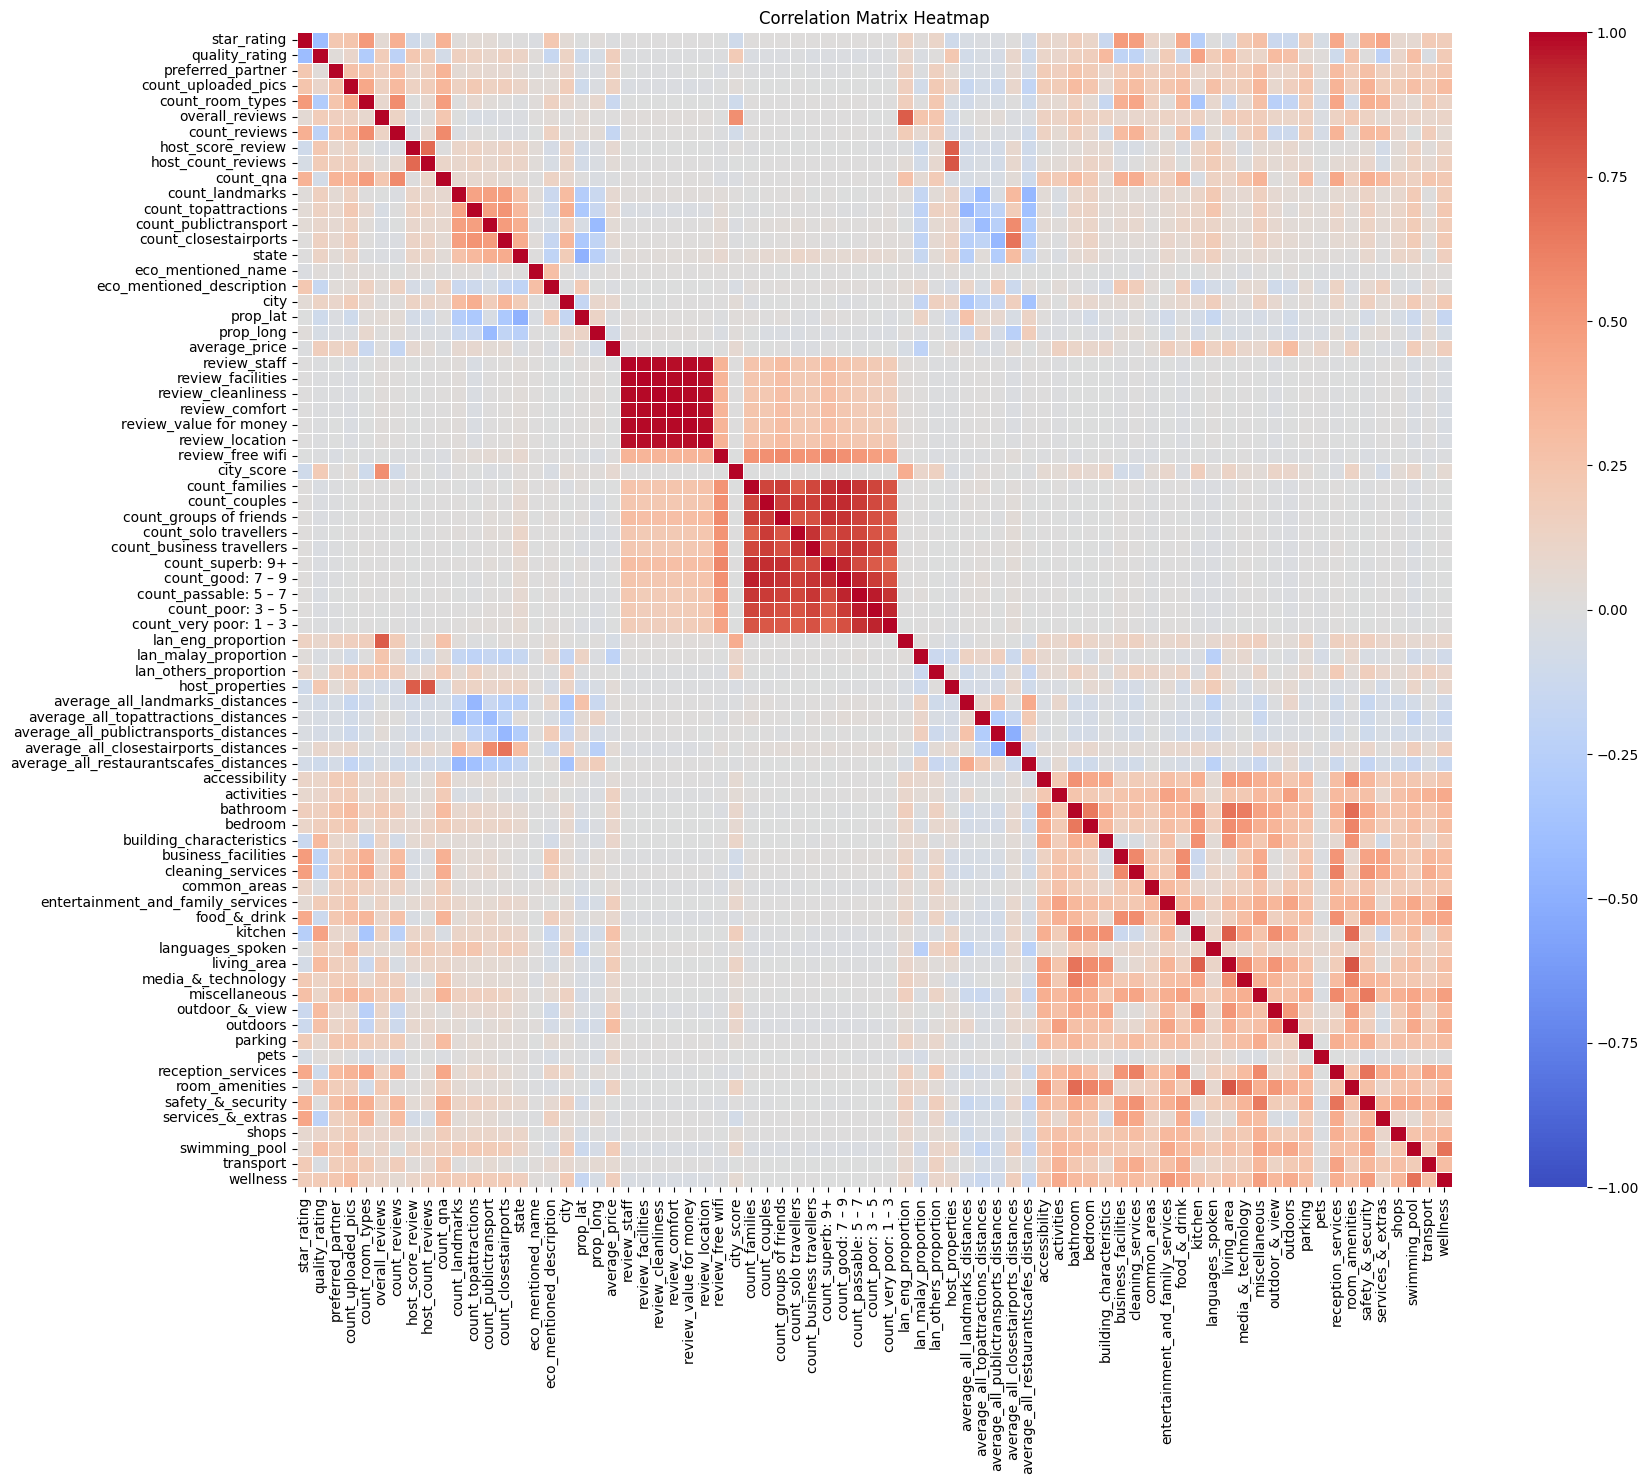

In [19]:
# Calculate the correlation matrix
corr_matrix = df.drop(columns=['sustainable_label']).corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True, square=True,
                      annot_kws={"size": 10}, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

Visually, it can be seen that features colorized in red have a high correlation to each other. To identify these highly correlated features more precisely, I set a threshold of 0.9. Any features scoring above this threshold will be detected. Once identified, I can safely remove these features from the dataset.

In [20]:
# Threshold for removing correlated features
threshold = 0.9

# Find pairs of correlated features
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

print(f"Highly correlated features to remove ({len(correlated_features)}):", correlated_features)

Highly correlated features to remove (11): {'count_very poor: 1 – 3', 'count_business travellers', 'review_comfort', 'count_superb: 9+', 'count_poor: 3 – 5', 'review_location', 'count_passable: 5 – 7', 'review_facilities', 'review_cleanliness', 'count_good: 7 – 9', 'review_value for money'}


In [21]:
corr_cols_drop = [
    'review_location', 
    'count_superb: 9+', 
    'count_very poor: 1 – 3', 
    'review_comfort', 
    'count_business travellers', 
    'count_poor: 3 – 5', 
    'review_value for money', 
    'count_good: 7 – 9', 
    'review_cleanliness', 
    'count_passable: 5 – 7', 
    'review_facilities'
]

df = df.drop(corr_cols_drop, axis=1)

### 3.3 Wrapper Method: Recursive Feature Elimination (RFE)

RFE is well-liked because it is simple to set up and apply, and it is good at identifying the features (columns) in a training dataset that are more or more pertinent to the target variable's prediction [(Brownlee, 2020)](https://machinelearningmastery.com/rfe-feature-selection-in-python/). Using it requires first configuring the class with the selected algorithm given by the estimator argument and the number of features to be selected by the n features to select argument. I have no clear idea of the desired or suitable number of features to create the model. According to [Brownlee (2020)](https://machinelearningmastery.com/rfe-feature-selection-in-python/) since we are unable to determine the ideal amount of features to use with RFE in practice, it is advisable to evaluate a range of values.

In [22]:
# setting up the RFE function
# get the dataset
def get_dataset(dataframe, target_column, cols_to_drop):
    y = dataframe[target_column]
    X = dataframe.drop(cols_to_drop, axis=1)
    return X, y

# get a list of models to evaluate
def get_models():
    models = dict()
    selected_features = dict()
    for i in range(2, 66): # X contains 66 features
        lr = LogisticRegression(solver='liblinear', random_state=42)
        rfe = RFE(estimator=lr, n_features_to_select=i)
        pipeline = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()), ('s', rfe), ('m', lr)])
        models[str(i)] = pipeline
        selected_features[str(i)] = rfe
    return models, selected_features

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # Fit StandardScaler and calculate precision-recall AUC
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    precision, recall, _ = precision_recall_curve(y, model.fit(X_scaled, y).predict_proba(X_scaled)[:,1])
    pr_auc = auc(recall, precision)
    scores['test_precision_recall_auc'] = [pr_auc] * len(scores['test_accuracy'])
    return scores

Apply the function to the dataset.

In [24]:
# Dataset preparation
cols_to_drop = ['sustainable_label']
X, y = get_dataset(df, 'sustainable_label', cols_to_drop)

# Get the models to evaluate
models, selected_features = get_models()

# Evaluate the models and store results
results = dict()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results[name] = scores

# Initialize a list to store the results for the DataFrame
results_list = []

# Obtain the mean scores for each metric and store them in the results list
for name, scores in results.items():
    result_row = {'Number of Features': name}
    for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_precision_recall_auc']:
        mean_score = np.mean(scores[metric])
        result_row[metric.replace('test_', '')] = mean_score
    results_list.append(result_row)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)
print(results_df)

c:\Users\asus\Documents\data_science\sustainable_ota\ota_venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=65 > n_features=64. There will be no feature selection and all features will be kept.
  warnings.warn(


   Number of Features  accuracy  precision    recall        f1  \
0                   2  0.746085   0.417503  0.762088  0.539395   
1                   3  0.752702   0.423854  0.743284  0.539808   
2                   4  0.754963   0.427594  0.753694  0.545570   
3                   5  0.757060   0.429849  0.749331  0.546191   
4                   6  0.756273   0.428742  0.749498  0.545383   
..                ...       ...        ...       ...       ...   
59                 61  0.777501   0.452876  0.674948  0.541991   
60                 62  0.777436   0.452764  0.674780  0.541857   
61                 63  0.777436   0.452774  0.674780  0.541865   
62                 64  0.777534   0.452937  0.674948  0.542034   
63                 65  0.777534   0.452937  0.674948  0.542034   

    precision_recall_auc  
0               0.522811  
1               0.535230  
2               0.536767  
3               0.553258  
4               0.574970  
..                   ...  
59              0.

Plotting the result of each metric

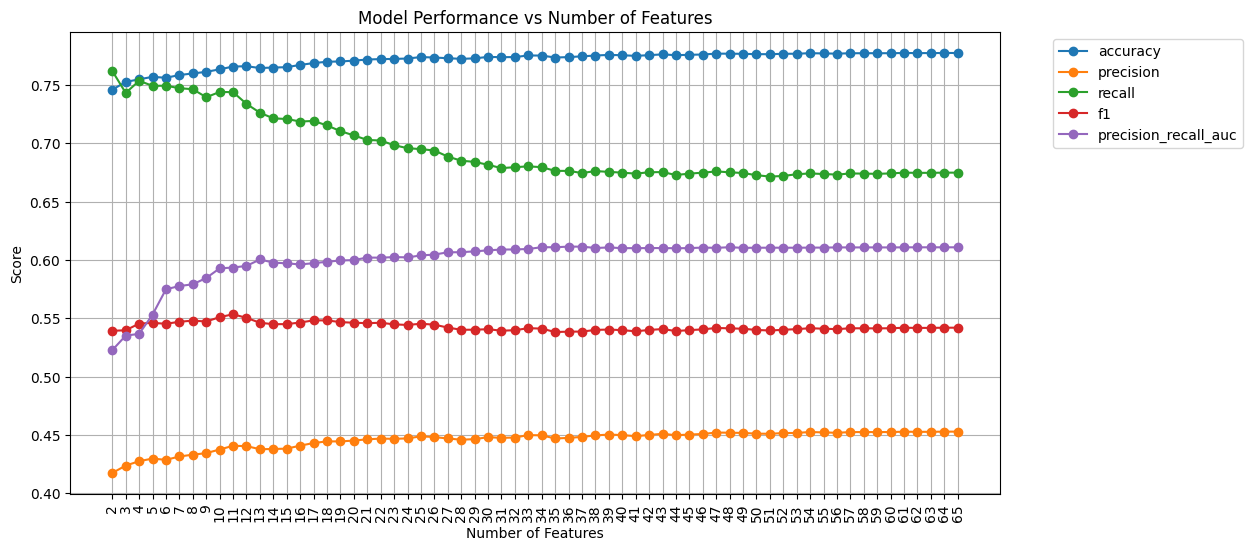

In [27]:
# Define the metrics to include in the plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'precision_recall_auc']

# Create a single plot for all metrics
plt.figure(figsize=(12, 6))

for metric in metrics_to_plot:
    # Extract scores for the current metric
    metric_scores = [np.mean(results[name][f'test_{metric}']) for name in results]
    
    # Plot the line plot for the current metric
    plt.plot(range(2, 2 + len(models)), metric_scores, marker='o', linestyle='-', label=metric)

# Customize the plot
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Model Performance vs Number of Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(range(2, 2 + len(models)), rotation=90)

# Show the plot
plt.show()

- Accuracy stabilizes after around 20 features.
- Recall starts high but slightly decreases after 5 features and becomes relatively stable around 22 features.
- Precision Recall AUC shows a noticeable increase and stabilizes around 10 features. It continues to show stable performance around the 11 to 22 feature range.
- F1 score improves significantly up to around 10 features, then shows minor improvements and stabilization, suggesting that increasing the number of features beyond 22 does not lead to significant improvements.
- Precision is the lowest performing metric across all feature counts but shows stability after 20 features.

### 3.4 Getting the Features

Obtaining the first 22 features from the model.

In [28]:
# getting the features that has been selected
selected_features_model = selected_features['22'].support_
selected_feature_names = X.columns[selected_features_model]
print(f"Selected Features for {len(selected_feature_names)} features model:", selected_feature_names)

Selected Features for 22 features model: Index(['quality_rating', 'preferred_partner', 'count_room_types',
       'overall_reviews', 'count_reviews', 'count_topattractions',
       'count_closestairports', 'count_groups of friends',
       'lan_eng_proportion', 'lan_malay_proportion',
       'average_all_closestairports_distances', 'bathroom',
       'business_facilities', 'common_areas', 'languages_spoken',
       'living_area', 'miscellaneous', 'outdoors', 'reception_services',
       'safety_&_security', 'services_&_extras', 'swimming_pool'],
      dtype='object')


### 3.5 Saving Result

In [26]:
results_dir = './../data/result/feature_selection_results.csv'
results_df.to_csv(results_dir, index=False)

### 3.6 Conclusion

- Initially removed 6 features from the sustainable section to avoid potential bias in the model.
- Removed an additional 2 features that contained constant data values.
- Applied Pearson correlation method and removed 11 highly correlated features using a threshold of 0.9.
- Employed RFE to identify the optimal number of features.
- Evaluation metrics indicated that using between 11 to 22 features would provide a balanced choice for further experimentation.
- Selected the first 22 features for subsequent analysis.